In [50]:
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import math

from utils_data import *
from Kmeans import *
from KNN import *
import numpy as np


root_folder = './images/'
json_file = './images/gt.json'

# Load all the images and GT
train_imgs, train_class_labels, train_color_labels, test_imgs, test_class_labels, \
    test_color_labels = read_dataset(root_folder=root_folder, gt_json=json_file)

# List with all the existent classes
classes = list(set(list(train_class_labels) + list(test_class_labels)))
# Load extended ground truth
imgs, class_labels, color_labels, upper, lower, background = read_extended_dataset()
cropped_images = crop_images(imgs, upper, lower)

(180, 80, 60, 3)
(180,)


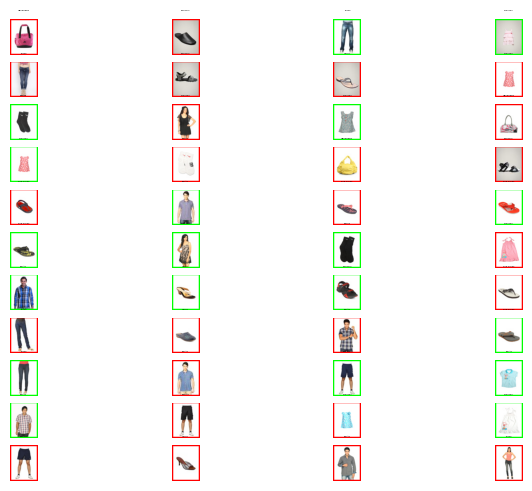

{'Dresses', 'Socks', 'Shorts', 'Handbags', 'Heels', 'Sandals', 'Shirts', 'Jeans', 'Flip Flops'}


In [51]:
# Prova

# using the function visualize_retrieval for the visualization of the retrieval results. Pass the class labels as information to be displayed
predicted = np.random.choice([True, False], len(cropped_images))
print(imgs.shape)
print(cropped_images.shape)
visualize_retrieval(imgs, topN=44, info=class_labels, ok=predicted)

print(set(class_labels))

## 4.1: Funcions d’anàlisi qualitatiu

### Retrieval_by_color (Aleix)

(180, 80, 60, 3)
(180, 80, 60, 3)


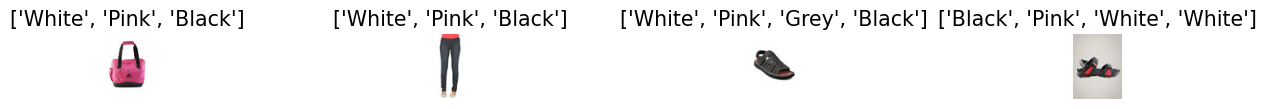

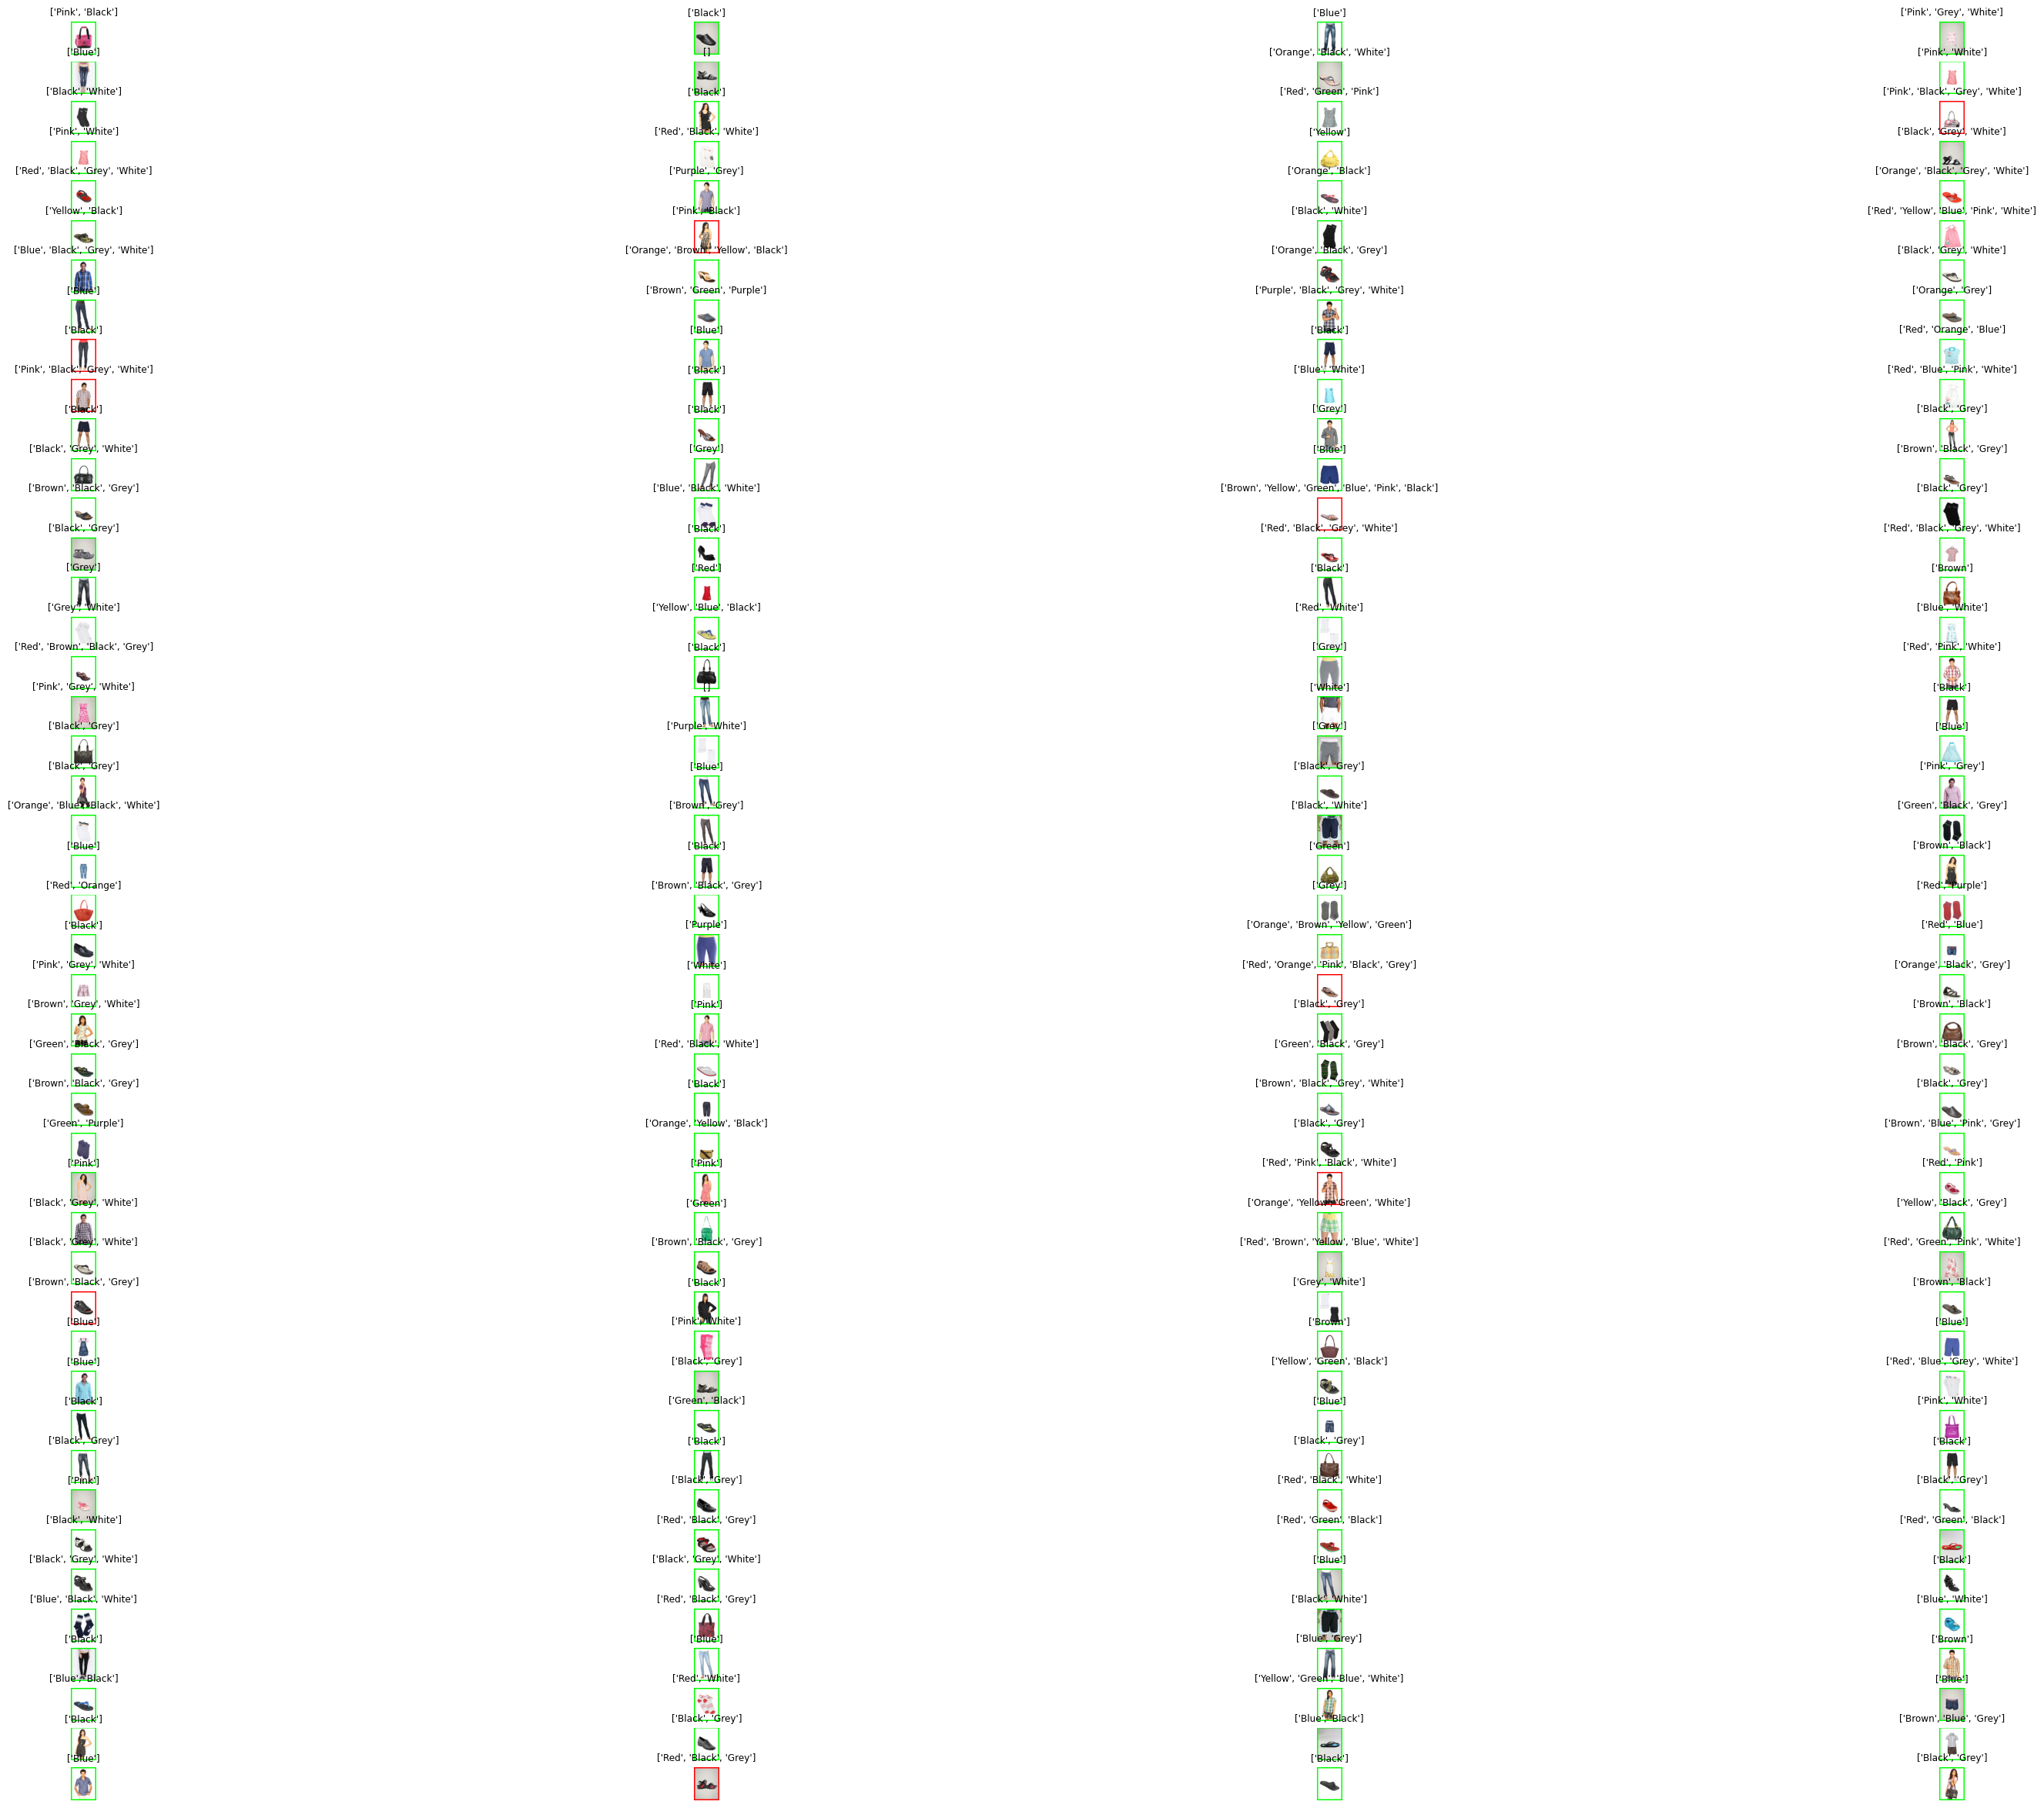

Correct predictions:  0.95


In [52]:
# Code
def Retrieval_by_color(imgs, color_labels, query_img):
    """
        Function to retrieve images by color
            Args:
                imgs: array with the images
                color_labels: array with the color labels
                query_img: list of strings with the query images.
                    Example: ['Red'] or ['Red', 'Black']
            Returns:
                imgs_retrieved: array with the images that have the same color as the query image
                color_labels_retrieved: array with the color labels of the images that have the same color as the query image
        """
    color_labels_retrieved = []
    if(len(imgs) != len(color_labels)):
        raise ValueError("imgs and color_labels must have the same length")
    imgs_retrieved = []
    #using zip to iterate over two lists at the same time
    for img, color in zip(imgs, color_labels):
        #check if all the colors in the query_img are in the color of the image
        if(all(x in color for x in query_img)):
            imgs_retrieved.append(img)
            color_labels_retrieved.append(color)
    return imgs_retrieved, color_labels_retrieved

def check_color_prediction(imgs, color_labels, color_labels_predicted, query_img):
    """
        Function to check if the color prediction is correct
            Args:
                imgs: array with the images
                color_labels: array with the color labels
                color_labels_predicted: array with the predicted color labels
                query_img: list of strings with the query images.
                    Example: ['Red'] or ['Red', 'Black']
            Returns:
                ok: array with the boolean values of the correct predictions
    """
    if(len(imgs) != len(color_labels) or len(imgs) != len(color_labels_predicted)):
        raise ValueError("imgs, color_labels and color_labels_predicted must have the same length")
    
    ok = []
    # Check if the color prediction is correct. If the color of the color_labels have all the colors in the query_img and the same as the color_labels_predicted, then it is correct.
    for color, color_predicted in zip(color_labels, color_labels_predicted):
        if(all(x in color for x in query_img)):
            if(all(x in color_predicted for x in query_img)):
                ok.append(True)
            else:
                ok.append(False)
        else:
            if not (all(x in color_predicted for x in query_img)):
                ok.append(True)
            else:
                ok.append(False)
    return ok


print(imgs.shape)
# imgs = imgs[:179]
print(imgs.shape)


query_img = np.array(['Black', 'Pink'])
# options
options = {'km_init': 'first', 'fitting': 'silhouette', 'tolerance': 5}
# KMeans
km_predicted_colors = []
# for img in imgs:
#     km = KMeans(X=img)
#     km.find_bestK(max_K=11)
#     km_predicted_colors.append(get_colors(km.centroids))


def process_image(img):
    km = KMeans(X=img, options=options)
    km.find_bestK(max_K=11)
    return get_colors(km.centroids)

def process_images(imgs, parallel):
    if parallel:
        from joblib import Parallel, delayed
        return Parallel(n_jobs=-1)(delayed(process_image)(img) for img in imgs)
    else:
        return [process_image(img) for img in imgs]
    
km_predicted_colors = process_images(imgs, parallel=True)

imgs_retrieved, colors_retrieved = Retrieval_by_color(imgs, km_predicted_colors, query_img=query_img)
visualize_retrieval(imgs_retrieved, topN=48, info=colors_retrieved, fac_size=2)
ok = check_color_prediction(imgs, color_labels[:len(imgs)], km_predicted_colors, query_img=query_img)
# Green: Image identified correctly. Red: Image identified incorrectly, can be a false positive or a false negative
visualize_retrieval(imgs, topN=len(imgs), info=color_labels, ok=ok, fac_size=5)
# print ratio of correct predictions
print("Correct predictions: ", np.sum(ok)/len(ok))

### Retrieval_by_shape (Jan)

In [53]:
# Code

### Retrieval_combined (Aleix)

In [54]:
# Code

## Funcions d’anàlisi quantitatiu

### Kmean_statistics (Jan)

In [55]:
# code

### Get_shape_accuracy (Aleix)

In [56]:
# Code 

### Get_color_accuracy (Jan)

In [57]:
# Code

## Millores als mètodes de classificació

### Inicializations de Kmeans

In [58]:
# Code

### Diferents heurístiques per BestK

In [59]:
# Code

### Find_BestK

In [60]:
# Code

### Features for KNN

In [61]:
# Code